In [1]:
%load_ext autoreload

%autoreload 2

In [3]:
from tqdm import tqdm
import time
import pickle
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy.stats import sem

from lifelines import KaplanMeierFitter

from bl_results_plots import km_plots, km_calculate, stats_plot

In [4]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

# 1 year predictions

/condor_data/sgcwhitl/Bayesian/results/New/1yeardeath_0607_1yd_norm_20test_hotelling_frac1.0_H_indices_100its_5pca_dir_1000samps

# 1 year predictions no asma

/condor_data/sgcwhitl/Bayesian/results/New/1yeardeath_1607_noasma_8pca

# 2 year predictions

2year_1507_2year_norm_20test_hotelling_frac1.0_H_indices_100its_8pca_dir_1000samps_noasma

# 2 year predictions no asma

/condor_data/sgcwhitl/Bayesian/results/New/2year_1607_noasma_8pca

In [5]:
FN = '/condor_data/sgcwhitl/Bayesian/results/New/1yeardeath_1607_noasma_8pca'

In [6]:
y_tests = []
blr_posteriors = []
lr_preds = []

In [41]:
samples = []

for i, hdf_name in enumerate(tqdm(glob.glob(FN + '**/**/*.hdf')[:])):

    sample_dict = dict()

    for pred_name in ['y_test', 'BLR_Posterior', 'LR_Preds']:

        sample_dict[pred_name] = pd.read_hdf(hdf_name, key=pred_name).astype(np.float16).reset_index('REF').reset_index(drop=True).set_index('REF')

    #samples.append(pd.concat(sample_dict, axis=1))
    samples.append(pd.concat(sample_dict,axis=1))

results = pd.concat(dict(enumerate(samples)))
results.index = results.index.set_names('Split', level=0)

100%|██████████| 76/76 [05:28<00:00,  4.33s/it]


In [9]:
results = pd.read_hdf('././1_year_prediction_asma.hdf', key='Data')

In [10]:
results.sample(5)

y_test BLR_Posterior                                          \
                0             0         1         2         3         4     
   REF                                                                      
31 TMA_1_G2     1.0      0.062683  0.061401  0.059113  0.064392  0.064148   
57 TMA_2_A2     0.0      0.483643  0.483398  0.481445  0.481934  0.482666   
67 TMA_1_F13    0.0      0.260986  0.259766  0.259033  0.259033  0.257812   
21 TMA_1_D10    0.0      0.032227  0.032166  0.032562  0.032349  0.032349   
61 TMA_1_F13    0.0      0.216675  0.216675  0.216919  0.217041  0.214844   

                                                      ...                      \
                   5         6         7         8    ...       992       993   
   REF                                                ...                       
31 TMA_1_G2   0.063110  0.062927  0.061951  0.061859  ...  0.062683  0.062683   
57 TMA_2_A2   0.480957  0.478760  0.483398  0.480469  ...  0.481445  0.481445   
67 TMA_1_F13  0.257324  0.257080  0.257568  0.260010  ...  0.261963  0.261963   
21 TMA_1_D10  0.032440  0.033783  0.033844  0.033325  ...  0.032928  0.032928   
61 TMA_1_F13  0.218506  0.219971  0.217896  0.218628  ...  0.217407  0.217529   

                                                                          \
                   994       995       996       997       998       999   
   REF                                                                     
31 TMA_1_G2   0.062683  0.062683  0.062866  0.062866  0.062866  0.062866   
57 TMA_2_A2   0.481445  0.481445  0.481445  0.480957  0.480469  0.480957   
67 TMA_1_F13  0.261963  0.261963  0.261963  0.261963  0.261963  0.259521   
21 TMA_1_D10  0.032928  0.032928  0.032654  0.032654  0.032654  0.033081   
61 TMA_1_F13  0.218750  0.218140  0.218384  0.214233  0.215698  0.215698   

              LR_Preds            
                   0         1    
   REF                            
31 TMA_1_G2   0.928223  0.071716  
57 TMA_2_A2   0.422119  0.577637  
67 TMA_1_F13  0.749512  0.250732  
21 TMA_1_D10  0.992676  0.007427  
61 TMA_1_F13  0.734863  0.265137  

[5 rows x 1003 columns]

results_dict_fn = glob.glob(FN + '**/*.pickle')[0]

with open(results_dict_fn, 'rb') as file_:

    results_dict = pickle.load(file_)

# Bayesian Logistic Regression

In [11]:
ts = np.linspace(0.2,0.9,20)

F1 = pd.DataFrame([{t: f1_score(y_true=row.xs('y_test', axis=1, level=0), y_pred=row.xs('BLR_Posterior', axis=1, level=0).mean(axis=1)>t) for t in ts} for i, row in tqdm(list(results.groupby('Split')))])

KeyError: 'Split'

In [8]:
ts = np.linspace(0.2,0.9,20)

F1 = pd.DataFrame([{t: f1_score(y_true=row['y_test'], y_pred=row['BLR_Posterior'].mean(axis=1)>t) for t in ts} for i, row in tqdm(list(results.iterrows()))])

100%|██████████| 73/73 [30:54<00:00, 25.41s/it]


{'AUC': 'A', 'MCC': 'B', 'Specificity': 'C', 'Sensitivity': 'D', 'PPV': 'E', 'NPV': 'F'}


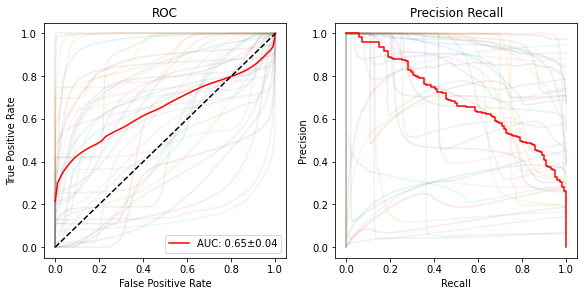

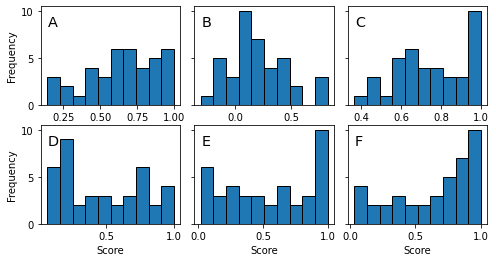

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (8,4), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []
threshs = []

for idx, row in results.loc[~(F1==0).any(axis=1)].iterrows():
#for idx, row in results.iterrows():

    probs = row['BLR_Posterior'].mean(axis=1)
    true = row['y_test']#[:,0]

    if len(np.unique(true)) == 1: continue

    ts = np.linspace(0.2,0.9,20)

    f1 = pd.Series({t: f1_score(y_true=true, y_pred=probs>t) for t in ts})
    best_threshold = f1.idxmax()

    preds = np.array([1 if el > 0.4 else 0 for el in probs])

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    stats['AUC'].append(roc_auc_score(true, probs))
    #stats['F1'].append(f1_score(y_true=true, y_pred=preds))
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

    threshs.append(best_threshold)

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--', c='black')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/BLR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/BLR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/roc_prec.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

#axes = pd.DataFrame(stats).hist(figsize=(12,7), layout=(2,3), sharey = True, w_pad=0, wspace=0);
#[ax.set_ylabel('Frequency') for ax in axes.flatten()]
#[ax.set_xlabel('Score') for ax in axes.flatten()]

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/stats.pdf", bbox_inches='tight')
print(f'Plots saved in {./plots/{FN.split('/')[-1][:-7]}}')

In [18]:
tsi, fsi = km_calculate(results.loc[~(F1==0).any(axis=1)], 'survival (months)', 'LR_Preds', 'DiedvsAlive')

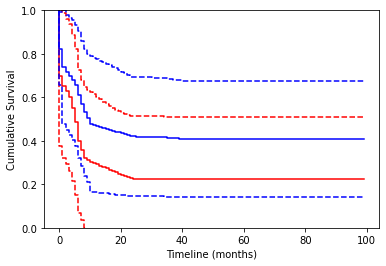

In [20]:
fig = km_plots(tsi, fsi);

# Logistic Regression

In [26]:
ts = np.linspace(0.2,0.9,20)

F1 = pd.DataFrame([{t: f1_score(y_true=row['y_test'], y_pred=row['LR_Preds'].iloc[:,1]>t) for t in ts} for i, row in tqdm(list(results.iterrows()))])



  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:00<00:35,  1.51it/s]

  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

  5%|▌         | 3/55 [00:01<00:27,  1.90it/s]

  7%|▋         | 4/55 [00:02<00:28,  1.77it/s]

  9%|▉         | 5/55 [00:02<00:30,  1.62it/s]

 11%|█         | 6/55 [00:03<00:25,  1.91it/s]

 13%|█▎        | 7/55 [00:03<00:20,  2.30it/s]

 15%|█▍        | 8/55 [00:03<00:19,  2.41it/s]

 16%|█▋        | 9/55 [00:04<00:17,  2.63it/s]

 18%|█▊        | 10/55 [00:04<00:13,  3.26it/s]

 20%|██        | 11/55 [00:04<00:14,  3.01it/s]

 22%|██▏       | 12/55 [00:04<00:14,  2.94it/s]

 24%|██▎       | 13/55 [00:05<00:12,  3.36it/s]

 25%|██▌       | 14/55 [00:05<00:12,  3.31it/s]

 27%|██▋       | 15/55 [00:05<00:10,  3.68it/s]

 29%|██▉       | 16/55 [00:05<00:09,  4.27it/s]

 31%|███       | 17/55 [00:06<00:13,  2.89it/s]

 33%|███▎      | 18/55 [00:06<00:13,  2.70it/s]

 35%|███▍      | 19/55 [00:07<00:12,  2.86it/s]

 36%|███▋      | 20/55 [00:07<00:09,

{'AUC': 'A', 'MCC': 'B', 'Specificity': 'C', 'Sensitivity': 'D', 'PPV': 'E', 'NPV': 'F'}
 plots saved in ./plots/1yeardeath_1607_noas/LR/stats.pdf


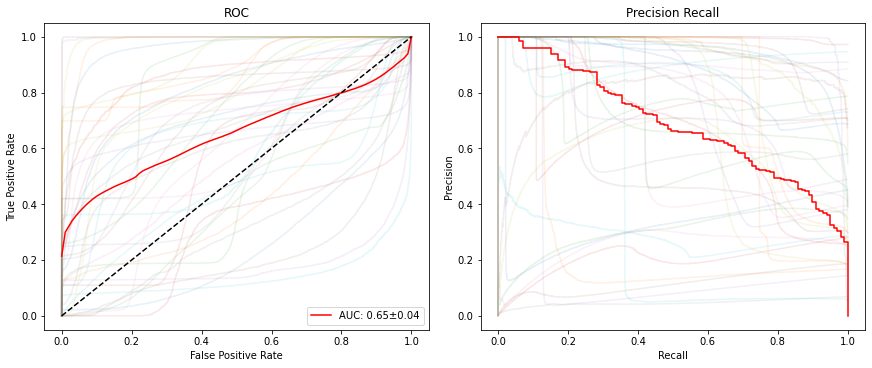

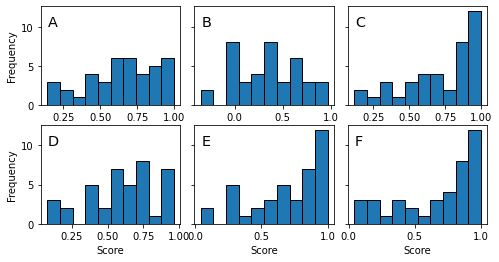

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

for idx, row in results.loc[~(F1==0).any(axis=1)].iterrows():
#for idx, row in results.iterrows():

    probs = row['LR_Preds'].iloc[:,1]
    true = row['y_test']#[:,0]

    if len(np.unique(true)) == 1: continue

    ts = np.linspace(0.2,0.9,20)

    f1 = pd.Series({t: f1_score(y_true=true, y_pred=probs>t) for t in ts})
    best_threshold = f1.idxmax()

    preds = np.array([1 if el > best_threshold else 0 for el in probs])

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    stats['AUC'].append(roc_auc_score(true, probs))
    #stats['F1'].append(f1_score(y_true=true, y_pred=preds))
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

    threshs.append(best_threshold)

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--', c='black')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/LR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/LR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/roc_prec.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/stats.pdf", bbox_inches='tight')
print(f" plots saved in ./plots/{FN.split('/')[-1][:-7]}/LR/stats.pdf")

# Filtered Bayesian

In [35]:
thres_results = []

for th in np.arange(30,70,5):

    for i, (idx, row) in enumerate(tqdm(list(results.iterrows())), start=1):

        try:
            perc = np.percentile(row['BLR_Posterior'].std(axis=1), th)
            indx = (row['BLR_Posterior'].std(axis=1) < perc).values#[0]

            #indx_s = np.random.randint(0,len(indx), 100)

            preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
            y_true = row['y_test'].values[indx]

            if len(np.unique(true)) ==1: continue

            thres_results.append({'Threshold': th,
                                'AUC': roc_auc_score(y_true, preds),
                                'Bootstrap':i})
        except IndexError as e:

            print('Index')

        except ValueError as e:
            print(e)
            print(f'Error: {th}')

KeyboardInterrupt: 

In [27]:
thresh_results = pd.DataFrame(thres_results)

In [28]:
thresh_results.groupby('Threshold').mean()

AUC  Bootstrap
Threshold                     
30         0.594305  35.343284
35         0.589444  35.308824
40         0.597705  35.742857
45         0.592263  36.098592
50         0.591830  36.098592
55         0.598015  36.098592
60         0.605415  36.098592
65         0.615054  36.098592

/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/s

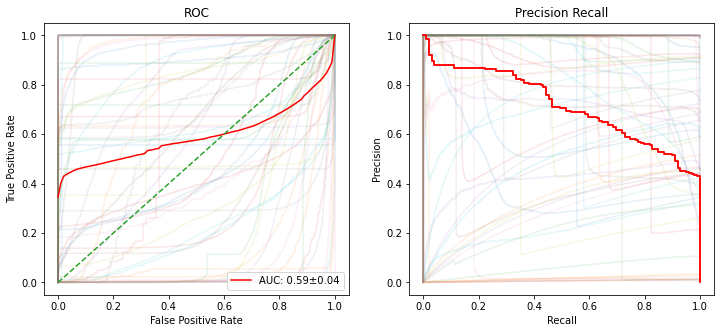

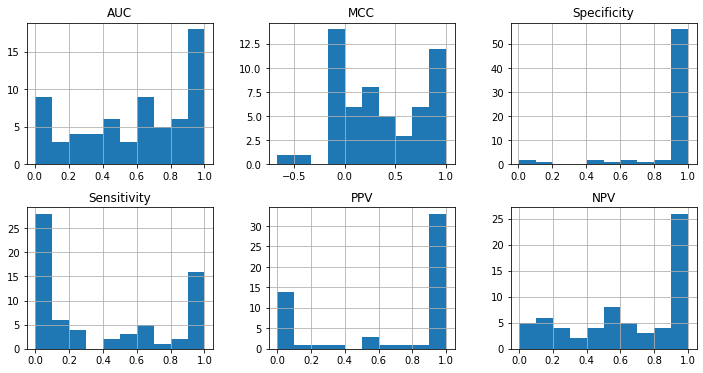

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

#for idx, row in results.loc[~(F1==0).any(axis=1)].iterrows():
for idx, row in results.iterrows():
    
    # Calculate nth percentile of standard deviations for each prediction
    perc = np.percentile(row['BLR_Posterior'].std(axis=1), 30)

    # Filter based on the percentile value
    indx = np.where(row['BLR_Posterior'].std(axis=1) < perc)[0]

    # Only take predictions and true values for those with the std dev
    # less than that given by the percentile value
    preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
    y_true = row['y_test'].values[indx]

    # Need to check if 0.5 is a suitable value
    predst = np.array([1 if el > 0.5 else 0 for el in preds])

    try:
        fpr, tpr, thresh = roc_curve(y_true, preds);

    except IndexError as e:

        print('index')
        continue
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(y_true, preds)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))


    cm = confusion_matrix(y_true, predst)
    try:
        tn, fp, fn, tp = cm.flatten()
    except:
        continue

    try:
        stats['AUC'].append(roc_auc_score(y_true, preds))
        stats['Specificity'].append(tn/(tn+fp))
        stats['Sensitivity'].append(tp/(tp+fn))
        stats['PPV'].append(tp/(tp+fp))
        stats['NPV'].append(tn/(tn+fn))
        stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    except:
        pass

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')


ax1.plot([0,1],[0,1], ls='--')

if not os.path.exists(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f"):

    os.makedirs(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/roc_prec.pdf", bbox_inches='tight')

#pd.DataFrame(stats).hist(figsize=(12,6), layout=(2,3));
#plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf", bbox_inches='tight')
print(f" plots saved in ./plots/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf")
